# **Import Library**

In [1]:
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
import altair as alt

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')

RendererRegistry.enable('colab')

# **Data Loading**

In [3]:
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [4]:
# Load masing masing dataset (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
# Genre pada setiap film bersifat biner.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [5]:
print('Jumlah data film: ', len(movies.movie_id.unique()))
print('Jumlah data pengunjung: ', len(users.user_id.unique()))
print('Jumlah data penayangan: ', len(ratings.user_id))

Jumlah data film:  1682
Jumlah data pengunjung:  943
Jumlah data penayangan:  100000


In [6]:
#mari kita ubah geser urutannya dimulai dari nol
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [7]:
#jumlah genre yang ada
genre_occurences = movies[genre_cols].sum().to_dict()
genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [8]:
#fungsi yang dapat menggabungkan genre menjadi satu buah string.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

In [9]:
movies['all_genres']

,all_genres
0,Animation-Children-Comedy
1,Action-Adventure-Thriller
2,Thriller
3,Action-Comedy-Drama
4,Crime-Drama-Thriller
...,...
1677,Drama
1678,Romance-Thriller
1679,Drama-Romance
1680,Comedy


In [10]:
#merging agar dataset yang ada menjadi satu buah kesatuan yang utuh.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')


# **Eksplorasi Data**

In [11]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [12]:
users.describe(include="all")

,user_id,age,sex,occupation,zip_code
count,943,943.000,943,943,943
unique,943,NaN,2,21,795
top,942,NaN,M,student,55414
freq,1,NaN,670,196,9
mean,NaN,34.052,NaN,NaN,NaN
...,...,...,...,...,...
min,NaN,7.000,NaN,NaN,NaN
25%,NaN,25.000,NaN,NaN,NaN
50%,NaN,31.000,NaN,NaN,NaN
75%,NaN,43.000,NaN,NaN,NaN


In [13]:
# Membuat filter untuk melakukan slicing data.
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# Fungsi yang dapat membuat histogram dari data yang sudah difilter.
def filtered_hist(field, label, filter):
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

/tmp/ipython-input-303782508.py:2: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  occupation_filter = alt.selection_multi(fields=["occupation"])


In [14]:
users_ratings = ratings.groupby(['user_id']).agg(
    rating_count=('rating', 'count'),
    rating_mean=('rating', 'mean')
).reset_index()
users_ratings = users.merge(users_ratings, on='user_id')

occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray"))
).add_selection(occupation_filter)

alt.hconcat(
    filtered_hist('rating_count', '# ratings / user', occupation_filter),
    filtered_hist('rating_mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

/tmp/ipython-input-307721590.py:7: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  occupation_filter = alt.selection_multi(fields=["occupation"])
/tmp/ipython-input-307721590.py:15: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).add_selection(occupation_filter)


alt.HConcatChart(...)

In [15]:
#Data film
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300).add_selection(genre_filter) # add selection here
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)


/tmp/ipython-input-241779020.py:8: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  genre_filter = alt.selection_multi(fields=['genre'])
/tmp/ipython-input-241779020.py:16: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  ).properties(height=300).add_selection(genre_filter) # add selection here


alt.HConcatChart(...)

In [18]:
#film rating terbaik
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating count', ascending=True)
 .head(10))

,title,rating count,rating mean
1146,My Family (1995),21,3.667
757,Lawnmower Man 2: Beyond Cyberspace (1996),21,1.714
542,"Misérables, Les (1995)",21,3.619
794,Richie Rich (1994),21,2.429
1120,"Umbrellas of Cherbourg, The (Parapluies de Che...",21,3.762
1085,It's My Party (1995),21,3.286
1083,Anne Frank Remembered (1995),21,3.857
815,Candyman: Farewell to the Flesh (1995),21,2.429
864,"Ice Storm, The (1997)",21,3.476
932,"Funeral, The (1996)",21,2.429


In [17]:
#Split Dataset Function
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

sebaiknya kita menggunakan fungsi tf.SparseTensor agar dapat melakukan komputasi dengan lebih efisien. Fungsi SparseTensor ini menggunakan tiga sensor untuk merepresentasikan matriks yaitu indices, values, dan dense_shape. Mari kita bahas ketiga parameter tersebut dengan lebih detail.

Indices
Indices adalah tensor yang berisi koordinat atau indeks dari elemen-elemen non-nol dalam tensor sparse. Bentuk tensor indices adalah [N, ndims], di mana N adalah jumlah elemen non-nol dan ndims adalah jumlah dimensi dari tensor spars.
Values
Values adalah tensor yang berisi nilai-nilai elemen non-nol yang sesuai dengan indeks yang diberikan dalam indices. Bentuk tensor values adalah [N], di mana N adalah jumlah elemen non-nol.
dense_shape
dense_shape adalah tensor yang menentukan bentuk lengkap dari tensor spars, termasuk elemen-elemen nol. Bentuk tensor dense_shape adalah [ndims], di mana ndims adalah jumlah dimensi dari tensor spars.

In [19]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

Kode di atas akan mengembalikan sebuah SparseTensor berdasarkan data ratings yang sudah disesuaikan dengan struktur user_id dan movie_id. Selain membuat fungsi di atas, kita juga perlu membuat sebuah fungsi yang dapat menghitung loss menggunakan pendekatan mean square error yang telah dipelajari pada modul sebelumnya.

In [20]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

Fungsi di atas memiliki tiga buah parameter seperti sparse_ratings, user_embeddings, dan movie_embeddings. Ketiga parameter itu memiliki fungsi yang berbeda. Lalu, apakah Anda penasaran apa isi dari parameter tersebut? Yuk, kita bahas semuanya.

sparse_ratings: matriks SparseTensor yang telah kita buat pada kode sebelumnya dengan bentuk larik [N, M].
user_embeddings: sebuah Tensor padat U dengan bentuk [N, k] di mana k adalah embedding sehingga U_i adalah embedding dari pengguna i.
movie_embeddings: sebuah Tensor padat V dengan bentuk [M, k] di mana k adalah dimensi penyematan dimensi embedding sehingga V_j adalah embedding dari film j.

In [21]:
class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [23]:
def build_model(ratings, embedding_dim, init_stddev):
  # Membagi dataset menjadi data latih dan data uji.
  train_ratings, test_ratings = split_dataframe(ratings)
  # Mengubah dataset menjadi SparseTensor.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Inisialisasi embedding menggunakan distribusi normal.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

Training

 iteration 1000: train_error=0.376047, test_error=1.336624

[{'train_error': np.float32(0.37604713), 'test_error': np.float32(1.3366243)}]

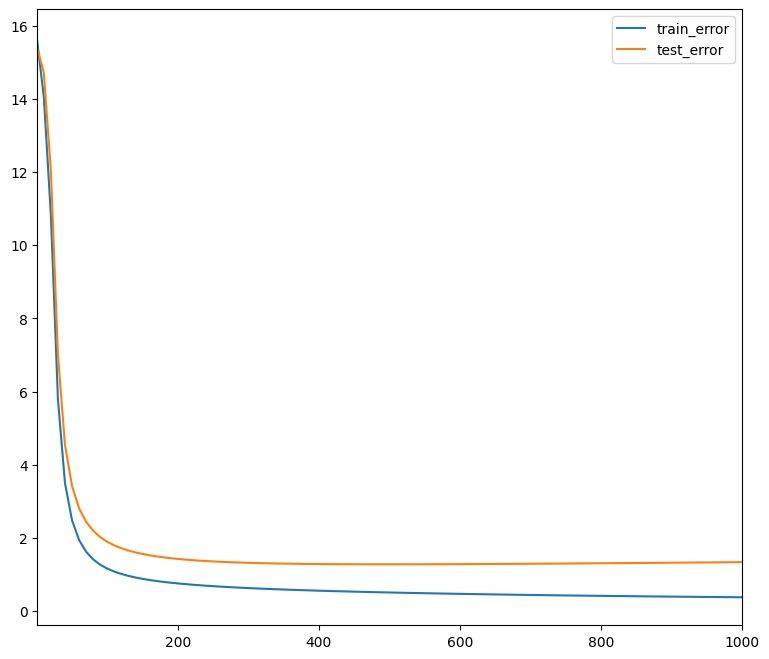

In [24]:
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

menghitung skor kesamaan antara data user dan item yang sudah melewati tahapan embedding menggunakan dua jenis ukuran kesamaan yaitu konstanta dot product dan cosine similarity.

In [25]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [26]:
def user_recommendations(model, measure=DOT, exclude_rated=True, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][942], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # Menghapus film yang sudah diberikan rating oleh user.
      rated_movies = ratings[ratings.user_id == "942"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))

Fungsi user_recommendations di atas bertugas untuk menghasilkan rekomendasi film bagi seorang pengguna berdasarkan model embedding yang telah dilatih.
Menghitung skor kesamaan antara embedding pengguna dan embedding semua film.
Membuat DataFrame yang berisi skor kesamaan, ID film, judul film, dan genre film.
Menghapus film yang sudah diberi rating oleh pengguna (jika exclude_rated adalah True).
Mengurutkan DataFrame berdasarkan skor kesamaan dan menampilkan sejumlah rekomendasi teratas yang ditentukan oleh parameter k.

Mari kita lihat output dari penggunaan fungsi berikut.

In [27]:
USER_RATINGS = True
user_recommendations(model, measure=COSINE, k=5)
user_recommendations(model, measure=DOT, k=5)

,cosine score,movie_id,titles,genres
1095,0.671,1095,Commandments (1997),Romance
664,0.611,664,Alien 3 (1992),Action-Horror-Sci-Fi-Thriller
332,0.609,332,"Game, The (1997)",Mystery-Thriller
590,0.605,590,Primal Fear (1996),Drama-Thriller
1461,0.600,1461,"Thieves (Voleurs, Les) (1996)",Crime-Drama-Romance


,dot score,movie_id,titles,genres
1461,7.098,1461,"Thieves (Voleurs, Les) (1996)",Crime-Drama-Romance
962,6.456,962,Some Folks Call It a Sling Blade (1993),Drama-Thriller
1084,6.115,1084,Carried Away (1996),Drama-Romance
323,5.954,323,Lost Highway (1997),Mystery
1128,5.910,1128,Chungking Express (1994),Drama-Mystery-Romance


Pada kasus ini, kita dapat membuat rekomendasi berdasarkan kemiripan genre dari masing-masing film.

In [28]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Mencari film berdasarkan judul yang dimasukkan.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [29]:
movie_neighbors(model, "Star Wars", DOT)
movie_neighbors(model, "Star Wars", COSINE)

Nearest neighbors of : Star Wars (1977).


,dot score,titles,genres
49,7.536,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
180,6.907,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
171,6.889,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
173,6.788,Raiders of the Lost Ark (1981),Action-Adventure
172,6.305,"Princess Bride, The (1987)",Action-Adventure-Comedy-Romance
63,6.293,"Shawshank Redemption, The (1994)",Drama


Nearest neighbors of : Star Wars (1977).


,cosine score,titles,genres
49,1.000,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
180,0.963,Return of the Jedi (1983),Action-Adventure-Romance-Sci-Fi-War
171,0.952,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
173,0.913,Raiders of the Lost Ark (1981),Action-Adventure
209,0.889,Indiana Jones and the Last Crusade (1989),Action-Adventure
221,0.865,Star Trek: First Contact (1996),Action-Adventure-Sci-Fi
